In [1]:
import importlib.util
from pathlib import Path
from typing import List, Optional

import pandas as pd
import requests

PUBLIC_LINK = "https://disk.360.yandex.ru/d/cGxh0ny6NI7NVw"
RESOURCE_URL = "https://cloud-api.yandex.net/v1/disk/public/resources"
DOWNLOAD_URL = f"{RESOURCE_URL}/download"


class YandexDiskClient:
    def __init__(self, public_link: str, session: Optional[requests.Session] = None) -> None:
        self.public_link = public_link
        self.session = session or requests.Session()

    def _list_dir(self, path: str = "") -> List[dict]:
        # Рекурсивно обходит папки и собирает информацию о всех файлах
        items: List[dict] = []
        offset = 0
        while True:
            params = {"public_key": self.public_link, "path": path, "limit": 1000, "offset": offset}
            resp = self.session.get(RESOURCE_URL, params=params, timeout=30)
            resp.raise_for_status()
            data = resp.json()
            embedded = data.get("_embedded", {})
            batch = embedded.get("items", [])
            if not batch:
                break
            for entry in batch:
                if entry.get("type") == "dir":
                    items.extend(self._list_dir(entry["path"]))
                elif entry.get("type") == "file":
                    items.append(entry)
            limit = embedded.get("limit", len(batch))
            total = embedded.get("total", offset + len(batch))
            offset += limit
            if offset >= total:
                break
        return items

    def list_files(self) -> List[dict]:
        return self._list_dir()

    def _download_url(self, path: str) -> str:
        resp = self.session.get(DOWNLOAD_URL, params={"public_key": self.public_link, "path": path}, timeout=30)
        resp.raise_for_status()
        href = resp.json().get("href")
        if not href:
            raise RuntimeError(f"Не удалось получить ссылку для скачивания: {path}")
        return href

    @staticmethod
    def _relative_path(yandex_path: str) -> Path:
        rel = yandex_path.split(":", 1)[-1].lstrip("/")
        return Path(rel)

    def download_file(self, file_info: dict, destination_root: Path) -> Path:
        # Качаем файл и сохраняем в ту же структуру папок
        rel_path = self._relative_path(file_info["path"])
        local_path = destination_root / rel_path
        local_path.parent.mkdir(parents=True, exist_ok=True)
        href = self._download_url(file_info["path"])
        with self.session.get(href, stream=True, timeout=120) as resp:
            resp.raise_for_status()
            with open(local_path, "wb") as fh:
                for chunk in resp.iter_content(chunk_size=1024 * 1024):
                    if chunk:
                        fh.write(chunk)
        return local_path


def is_colab() -> bool:
    return importlib.util.find_spec("google.colab") is not None


def get_base_dir() -> Path:
    # Определяем среду: Google Colab или локальный компьютер, и готовим папку вывода
    if is_colab():
        try:
            from google.colab import drive
        except ModuleNotFoundError as err:
            raise RuntimeError("Обнаружен Colab, но модуль google.colab недоступен.") from err
        drive.mount("/content/drive", force_remount=False)
        base = Path("/content/drive/MyDrive/yandex_disk_downloads")
    else:
        base = Path.cwd() / "yandex_disk_downloads"
    base.mkdir(parents=True, exist_ok=True)
    return base


def read_tabular(path: Path) -> Optional[pd.DataFrame]:
    suffix = path.suffix.lower()
    try:
        if suffix in {".xlsx", ".xls", ".xlsm"}:
            return pd.read_excel(path)
        if suffix in {".csv", ".txt"}:
            return pd.read_csv(path)
        if suffix == ".tsv":
            return pd.read_csv(path, sep="\t")
        if suffix == ".parquet":
            return pd.read_parquet(path)
    except Exception as exc:
        print(f"Пропускаю {path} — ошибка чтения: {exc}")
    return None


def sanitize_for_parquet(df: pd.DataFrame) -> pd.DataFrame:
    # Приводим проблемные колонки к строкам и декодируем bytes, чтобы pyarrow не падал
    out = df.copy()
    obj_cols = out.columns

    def _to_text(val):
        if isinstance(val, bytes):
            try:
                return val.decode("utf-8")
            except UnicodeDecodeError:
                return val.decode("latin-1", errors="replace")
        return val

    for col in obj_cols:
        series = out[col]
        contains_text = series.apply(lambda v: isinstance(v, (str, bytes))).any()
        if contains_text or pd.api.types.is_object_dtype(series):
            out[col] = series.map(_to_text)
            # Приводим к строковому типу, сохраняя пропуски как <NA>
            out[col] = out[col].astype("string")
    return out


def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    # Унифицируем названия колонок: убираем пробелы, неразрывные пробелы и приводим к нижнему регистру
    renames = {}
    for col in df.columns:
        name = "" if pd.isna(col) else str(col)
        normalized = name.replace("\xa0", " ").strip().lower()
        renames[col] = normalized
    return df.rename(columns=renames)


def align_columns_by_order(df: pd.DataFrame, base_columns: Optional[List[str]]) -> (pd.DataFrame, List[str]):
    """
    Выравнивает названия по порядку колонок. Если имя пустое, даём имя col_<index>.
    Если базовый порядок уже известен, применяем его по позициям.
    Возвращает (DataFrame, итоговый список колонок).
    """
    # нормализуем
    df = normalize_columns(df)
    col_names: List[str] = []
    for idx, col in enumerate(df.columns):
        name = "" if pd.isna(col) else str(col)
        name = name.replace("\xa0", " ").strip().lower()
        if not name:
            name = f"col_{idx}"
        col_names.append(name)

    if base_columns is None:
        # формируем базовый порядок по первому файлу
        rename_map = {old: new for old, new in zip(df.columns, col_names)}
        return df.rename(columns=rename_map), col_names

    # Если есть базовый порядок, выравниваем по позиции
    rename_map = {}
    for idx, old in enumerate(df.columns):
        target = base_columns[idx] if idx < len(base_columns) else f"col_{idx}"
        rename_map[old] = target
    aligned = df.rename(columns=rename_map)
    # если в этом файле меньше колонок, добавим пустые для недостающих позиций
    for idx in range(len(base_columns)):
        if base_columns[idx] not in aligned.columns:
            aligned[base_columns[idx]] = pd.NA
    # если базовый порядок короче, обрежем лишние столбцы
    aligned = aligned.reindex(columns=base_columns)
    return aligned, base_columns


def ask_files_already_downloaded() -> bool:
    # Узнаём у пользователя, нужно ли скачивать файлы заново
    answer = input("Файлы уже скачаны в целевую папку? (y/n): ").strip().lower()
    return answer in {"y", "yes", "д", "да"}


def collect_local_files(root: Path) -> List[Path]:
    # Собираем все файлы локально (рекурсивно), исключая итоговый parquet
    return [p for p in root.rglob("*") if p.is_file() and p.name != "combined.parquet"]


def build_parquet(downloaded_files: List[Path], destination_root: Path) -> Optional[Path]:
    tabular_suffixes = {".xlsx", ".xls", ".xlsm", ".csv", ".txt", ".tsv", ".parquet"}
    frames: List[pd.DataFrame] = []
    base_columns: Optional[List[str]] = None
    for file_path in downloaded_files:
        if file_path.suffix.lower() not in tabular_suffixes:
            continue
        df = read_tabular(file_path)
        if df is not None and not df.empty:
            df, base_columns = align_columns_by_order(df, base_columns)
            df = sanitize_for_parquet(df)
            df["__source_file"] = str(file_path.relative_to(destination_root))
            frames.append(df)
    if not frames:
        print("Табличные файлы не найдены, объединять нечего.")
        return None
    combined = pd.concat(frames, ignore_index=True)
    # Финальная нормализация типов перед записью
    combined = sanitize_for_parquet(combined)
    output_path = destination_root / "combined.parquet"
    try:
        combined.to_parquet(output_path, index=False)
    except ImportError as exc:
        raise RuntimeError(
            "Для записи в Parquet нужен пакет 'pyarrow' или 'fastparquet'. Установите один из них."
        ) from exc
    return output_path


def save_csv(combined: pd.DataFrame, destination_root: Path) -> Path:
    output_path = destination_root / "combined.csv"
    combined.to_csv(output_path, index=False)
    return output_path


def main() -> None:
    base_dir = get_base_dir()
    print(f"Файлы сохраняются в: {base_dir}")
    if ask_files_already_downloaded():
        print("Скачивание пропущено по просьбе пользователя. Использую локальные файлы.")
        downloaded = collect_local_files(base_dir)
        if not downloaded:
            print("Локальные файлы не найдены. Попробуйте запустить заново и выбрать скачивание.")
            return
    else:
        client = YandexDiskClient(PUBLIC_LINK)
        print("Получаю список файлов на Яндекс Диске...")
        files = client.list_files()
        print(f"Найдено файлов: {len(files)}. Начинаю скачивание...")

        downloaded = []
        for idx, info in enumerate(files, start=1):
            try:
                local_file = client.download_file(info, base_dir)
                downloaded.append(local_file)
                print(f"[{idx}/{len(files)}] Скачан файл: {local_file}")
            except Exception as exc:
                print(f"[{idx}/{len(files)}] Не удалось скачать {info.get('name')}: {exc}")

    parquet_path = build_parquet(downloaded, base_dir)
    if parquet_path:
        print(f"Parquet файл создан: {parquet_path}")
        # Дополнительно сохраняем CSV для совместимости
        try:
            csv_path = save_csv(pd.read_parquet(parquet_path), base_dir)
            print(f"CSV файл создан: {csv_path}")
        except Exception as exc:
            print(f"Не удалось сохранить CSV: {exc}")
    else:
        print("Parquet не создан, так как табличные файлы не обработаны.")


if __name__ == "__main__":
    main()

Mounted at /content/drive
Файлы сохраняются в: /content/drive/MyDrive/yandex_disk_downloads
Файлы уже скачаны в целевую папку? (y/n): n
Получаю список файлов на Яндекс Диске...
Найдено файлов: 45. Начинаю скачивание...
[1/45] Скачан файл: /content/drive/MyDrive/yandex_disk_downloads/Данные/2022/Август 2022.xlsx
[2/45] Скачан файл: /content/drive/MyDrive/yandex_disk_downloads/Данные/2022/Апрель 2022.xlsx
[3/45] Скачан файл: /content/drive/MyDrive/yandex_disk_downloads/Данные/2022/Декабрь 2022.xlsx
[4/45] Скачан файл: /content/drive/MyDrive/yandex_disk_downloads/Данные/2022/Июль 2022.xlsx
[5/45] Скачан файл: /content/drive/MyDrive/yandex_disk_downloads/Данные/2022/Июнь 2022.xlsx
[6/45] Скачан файл: /content/drive/MyDrive/yandex_disk_downloads/Данные/2022/Май 2022.xlsx
[7/45] Скачан файл: /content/drive/MyDrive/yandex_disk_downloads/Данные/2022/Март 2022.xlsx
[8/45] Скачан файл: /content/drive/MyDrive/yandex_disk_downloads/Данные/2022/Ноябрь 2022.xlsx
[9/45] Скачан файл: /content/drive/My

In [40]:
data = pd.read_csv('/content/drive/MyDrive/yandex_disk_downloads/combined.csv')

/tmp/ipython-input-567746733.py:1: DtypeWarning: Columns (2,4,6,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/yandex_disk_downloads/combined.csv')


In [34]:
data.ещ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545666 entries, 0 to 545665
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   проект                545640 non-null  float64
 1   коммерческий проект   545665 non-null  object 
 2   id задачи             545502 non-null  object 
 3   название задачи       545060 non-null  object 
 4   работник              545617 non-null  object 
 5   должность             545617 non-null  object 
 6   время (час)           545666 non-null  object 
 7   дата                  545666 non-null  object 
 8   комментарии (работы)  381626 non-null  object 
 9   теги                  141089 non-null  object 
 10  тип задачи            502002 non-null  object 
 11  родитель_1_ид         544558 non-null  object 
 12  __source_file         545666 non-null  object 
dtypes: float64(1), object(12)
memory usage: 54.1+ MB


In [60]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Аналитика списания рабочего времени по проектам ООО "Лоция"
и построение модели планирования человеко-часов.

Как использовать:
    python locia_time_analysis.py --input combined.csv --output ./output

Скрипт:
- загружает и очищает данные;
- вычисляет агрегаты по проектам и ролям;
- строит укрупнённые группы ролей;
- сегментирует проекты по размеру;
- считает типовые профили ролей для малых/средних/крупных проектов;
- сохраняет результаты в csv и строит несколько графиков.

Требуемые пакеты: pandas, numpy, matplotlib (для графиков):
    pip install pandas numpy matplotlib
"""

import argparse
from pathlib import Path
from typing import Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# -----------------------------
# Константы и настройки
# -----------------------------

SMALL_PROJECT_HOURS = 200      # < 200 ч
LARGE_PROJECT_HOURS = 2000     # > 2000 ч

ROLE_GROUP_COLUMN = "роль_группа"
PROJECT_SIZE_COLUMN = "размер_проекта"


# -----------------------------
# Загрузка и очистка данных
# -----------------------------

def load_raw_data(path: Path) -> pd.DataFrame:
    print(f"[INFO] Читаю файл как байты...")

    # Читаем содержимое файла как необработанные байты
    with open(path, "rb") as f:
        raw = f.read()

    # Пробуем декодировать в UTF-8, заменяя ошибки
    text = raw.decode("utf-8", errors="replace")

    # Теперь создаём dataframe из текста
    from io import StringIO
    df = pd.read_csv(
        StringIO(text),
        sep=None,
        engine="python",
        on_bad_lines="skip",
        quoting=3,
        dtype=str
    )

    print(f"[INFO] Загружено строк: {len(df)}, колонок: {len(df.columns)}")
    return df


def drop_misaligned_rows(df: pd.DataFrame) -> pd.DataFrame:
    """
    Удаление строк, где колонка 'коммерческий проект' содержит
    не 'Да'/'Нет', а числовое значение id проекта (сдвиг колонок).
    Такие строки невозможно корректно восстановить.
    """
    col = "коммерческий проект"
    mask_bad = ~df[col].isin(["Да", "Нет"]) & df[col].notna()
    bad_count = mask_bad.sum()
    if bad_count:
        print(f"[WARN] Обнаружено строк со сдвигом колонок: {bad_count}. Они будут удалены.")
        df = df.loc[~mask_bad].copy()
    else:
        print("[INFO] Строк со сдвигом колонок не обнаружено.")
    return df


def basic_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    """
    Базовая очистка:
    - приведение типов;
    - удаление явных аномалий (отрицательные часы);
    - фильтрация нулевых часов (опционально — помечаем, но не удаляем).
    """
    df = df.copy()

    # Часы
    hours_col = "время (час)"
    df[hours_col] = pd.to_numeric(df[hours_col], errors="coerce")

    # Дата
    date_col = "дата"
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce", dayfirst=True)

    # Проект
    project_col = "проект"
    # В файле проект представлен как число с плавающей точкой, приведём к строке
    df[project_col] = df[project_col].astype(str).str.strip()

    # Флаг коммерческого проекта
    commercial_col = "коммерческий проект"
    df[commercial_col] = df[commercial_col].astype(str).str.strip()
    df[commercial_col] = df[commercial_col].where(df[commercial_col].isin(["Да", "Нет"]), np.nan)

    # Отрицательные часы — удаляем
    neg_mask = df[hours_col] < 0
    neg_count = neg_mask.sum()
    if neg_count:
        print(f"[WARN] Строк с отрицательными часами: {neg_count}. Они будут удалены.")
        df = df.loc[~neg_mask].copy()

    # Нулевые часы — оставляем, но можно пометить
    zero_mask = df[hours_col] == 0
    zero_count = zero_mask.sum()
    print(f"[INFO] Строк с нулевыми часами: {zero_count} (не удаляются).")

    # Удаляем строки без даты или без часов
    before = len(df)
    df = df.dropna(subset=[hours_col, date_col])
    after = len(df)
    print(f"[INFO] Удалено строк без даты/часов: {before - after}.")

    return df


# -----------------------------
# Группировка должностей в укрупнённые роли
# -----------------------------

def map_position_to_role_group(position: str) -> str:
    """
    Грубое маппирование должности в укрупнённую роль на основе ключевых слов.
    При необходимости словарь можно донастроить под реальные должности.
    """
    if not isinstance(position, str):
        return "прочее"

    p = position.lower()

    # Порядок важен: от более специфических к более общим
    if "руководитель проектов" in p or "project manager" in p or "pm" in p:
        return "управление проектом"
    if "аналитик" in p or "business analyst" in p:
        return "аналитика"
    if "тестиров" in p or "qa" in p or "quality" in p:
        return "тестирование"
    if "дизайн" in p or "ux" in p or "ui" in p:
        return "дизайн"
    if "архитектор" in p or "архитектура" in p:
        return "архитектура"
    if "база данных" in p or "бд" in p or "dba" in p or "эксплуатац" in p or "администратор баз данных" in p:
        return "бд/эксплуатация"
    if "devops" in p or "администрирован" in p or "администратор" in p:
        return "бд/эксплуатация"
    if "директор" in p or "генеральный" in p or "топ-менеджмент" in p:
        return "топ-менеджмент"
    if "разработ" in p or "developer" in p or "программист" in p or "инженер-программист" in p:
        return "разработка"

    return "прочее"


def add_role_group(df: pd.DataFrame) -> pd.DataFrame:
    """Добавить колонку с укрупнённой ролью."""
    df = df.copy()
    df[ROLE_GROUP_COLUMN] = df["должность"].apply(map_position_to_role_group)
    return df


# -----------------------------
# Агрегаты по проектам и ролям
# -----------------------------

def build_project_level_aggregation(df: pd.DataFrame) -> pd.DataFrame:
    """
    Агрегаты по проектам:
    - суммарные часы;
    - первая и последняя дата;
    - длительность;
    - число сотрудников;
    - число должностей и укрупнённых ролей;
    - статус коммерческий/некоммерческий.
    """
    hours_col = "время (час)"
    date_col = "дата"
    project_col = "проект"

    grouped = df.groupby(project_col)

    proj = grouped.agg(
        total_hours=(hours_col, "sum"),
        start_date=(date_col, "min"),
        end_date=(date_col, "max"),
        employees=("работник", "nunique"),
        positions=("должность", "nunique"),
        role_groups=(ROLE_GROUP_COLUMN, "nunique"),
    ).reset_index()

    proj["duration_days"] = (proj["end_date"] - proj["start_date"]).dt.days + 1

    # Определить коммерческий/некоммерческий по мажоритарному признаку
    commercial = df.groupby(project_col)["коммерческий проект"].agg(
        lambda x: x.value_counts(dropna=True).index[0] if x.notna().any() else np.nan
    ).reset_index().rename(columns={"коммерческий проект": "коммерческий"})

    proj = proj.merge(commercial, on=project_col, how="left")

    print(f"[INFO] Агрегация по проектам: {len(proj)} проектов.")
    return proj


def add_project_size_segment(projects: pd.DataFrame) -> pd.DataFrame:
    """Добавить колонку с размером проекта по суммарным часам."""
    projects = projects.copy()

    def _segment(h: float) -> str:
        if h < SMALL_PROJECT_HOURS:
            return "малый"
        if h > LARGE_PROJECT_HOURS:
            return "крупный"
        return "средний"

    projects[PROJECT_SIZE_COLUMN] = projects["total_hours"].apply(_segment)
    return projects


def compute_role_profiles(df: pd.DataFrame, projects: pd.DataFrame) -> pd.DataFrame:
    """
    Рассчитать средние профили распределения часов по укрупнённым ролям
    для разных классов проектов (малый/средний/крупный).
    """
    hours_col = "время (час)"
    project_col = "проект"

    # Присоединяем размер проекта к строчкам списания
    proj_sizes = projects[[project_col, PROJECT_SIZE_COLUMN]]
    df_with_size = df.merge(proj_sizes, on=project_col, how="left")

    # Группировка по размеру проекта и роли
    grouped = (
        df_with_size
        .groupby([PROJECT_SIZE_COLUMN, ROLE_GROUP_COLUMN])[hours_col]
        .sum()
        .reset_index()
    )

    # Считаем долю ролей внутри каждого класса
    total_by_size = grouped.groupby(PROJECT_SIZE_COLUMN)[hours_col].transform("sum")
    grouped["share"] = grouped[hours_col] / total_by_size

    # Для удобства — сводная таблица
    pivot = grouped.pivot(
        index=PROJECT_SIZE_COLUMN,
        columns=ROLE_GROUP_COLUMN,
        values="share"
    ).fillna(0)

    print("[INFO] Типовые профили ролей по размеру проекта (доля часов):")
    print(pivot.round(3))

    return grouped, pivot.reset_index()


# -----------------------------
# Визуализация
# -----------------------------

def ensure_output_dir(path: Path) -> None:
    path.mkdir(parents=True, exist_ok=True)


def plot_project_size_distribution(projects: pd.DataFrame) -> None:
    """Гистограмма распределения проектов по суммарным часам (показывается на экране)."""
    plt.figure()
    projects["total_hours"].plot(kind="hist", bins=50)
    plt.xlabel("Суммарные часы на проект")
    plt.ylabel("Количество проектов")
    plt.title("Распределение проектов по суммарным часам")
    plt.tight_layout()
    plt.show()


def plot_role_shares_overall(df: pd.DataFrame) -> None:
    """Круговая диаграмма по ролям (показывается на экране)."""
    hours_col = "время (час)"
    role_hours = df.groupby(ROLE_GROUP_COLUMN)[hours_col].sum().sort_values(ascending=False)

    plt.figure()
    role_hours.plot(kind="pie", autopct="%1.1f%%", ylabel="")
    plt.title("Распределение трудозатрат по укрупнённым ролям")
    plt.tight_layout()
    plt.show()


def plot_role_profiles_by_size(pivot_profiles: pd.DataFrame) -> None:
    """Stacked bar: профили ролей по размерам проектов."""
    df = pivot_profiles.set_index(PROJECT_SIZE_COLUMN)
    df = df.sort_index()

    plt.figure()
    bottom = np.zeros(len(df))
    x = np.arange(len(df.index))

    for role in df.columns:
        plt.bar(x, df[role].values, bottom=bottom, label=role)
        bottom += df[role].values

    plt.xticks(x, df.index)
    plt.ylabel("Доля часов")
    plt.title("Профили ролей по классам проектов")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


# -----------------------------
# Основной сценарий
# -----------------------------

def main(input_path: str, output_dir: str) -> None:
    input_path = Path(input_path)
    output_dir = Path(output_dir)
    ensure_output_dir(output_dir)

    # 1. Загрузка и очистка
    df_raw = load_raw_data(input_path)
    df = drop_misaligned_rows(df_raw)
    df = basic_cleaning(df)
    df = add_role_group(df)

    # Сохраняем очищенный файл — пусть остаётся
    cleaned_path = output_dir / "combined_cleaned.csv"
    df.to_csv(cleaned_path, index=False)
    print(f"[INFO] Очищенные данные сохранены в {cleaned_path}")

    # 2. Агрегаты по проектам
    projects = build_project_level_aggregation(df)
    projects = add_project_size_segment(projects)

    projects_path = output_dir / "projects_summary.csv"
    projects.to_csv(projects_path, index=False)
    print(f"[INFO] Агрегаты по проектам сохранены в {projects_path}")

    # 3. Профили ролей
    role_profiles_long, role_profiles_pivot = compute_role_profiles(df, projects)

    profiles_long_path = output_dir / "role_profiles_by_size_long.csv"
    profiles_pivot_path = output_dir / "role_profiles_by_size_pivot.csv"
    role_profiles_long.to_csv(profiles_long_path, index=False)
    role_profiles_pivot.to_csv(profiles_pivot_path, index=False)

    print(f"[INFO] Профили ролей сохранены в {profiles_long_path} и {profiles_pivot_path}")

    # 4. Теперь — показываем графики
    plot_project_size_distribution(projects)
    plot_role_shares_overall(df)
    plot_role_profiles_by_size(role_profiles_pivot)

    # 5. Сводка
    total_hours = df["время (час)"].sum()
    n_projects = projects.shape[0]
    n_employees = df["работник"].nunique()
    n_positions = df["должность"].nunique()

    print("\n===== СВОДКА =====")
    print(f"Всего проектов: {n_projects}")
    print(f"Всего уникальных сотрудников: {n_employees}")
    print(f"Всего уникальных должностей: {n_positions}")
    print(f"Суммарно списано часов: {total_hours:,.0f}")
    print("===================")

[INFO] Читаю файл как байты...
[INFO] Загружено строк: 117127, колонок: 13
[WARN] Обнаружено строк со сдвигом колонок: 1433. Они будут удалены.
[INFO] Строк с нулевыми часами: 454 (не удаляются).
[INFO] Удалено строк без даты/часов: 2.
[INFO] Очищенные данные сохранены в output/combined_cleaned.csv
[INFO] Агрегация по проектам: 187 проектов.
[INFO] Агрегаты по проектам сохранены в output/projects_summary.csv
[INFO] Типовые профили ролей по размеру проекта (доля часов):
роль_группа     аналитика  архитектура  бд/эксплуатация  дизайн  прочее  \
размер_проекта                                                            
крупный             0.135        0.014            0.011   0.048   0.230   
малый               0.183        0.064            0.023   0.033   0.286   
средний             0.211        0.016            0.030   0.039   0.263   

роль_группа     разработка  тестирование  топ-менеджмент  управление проектом  
размер_проекта                                                        

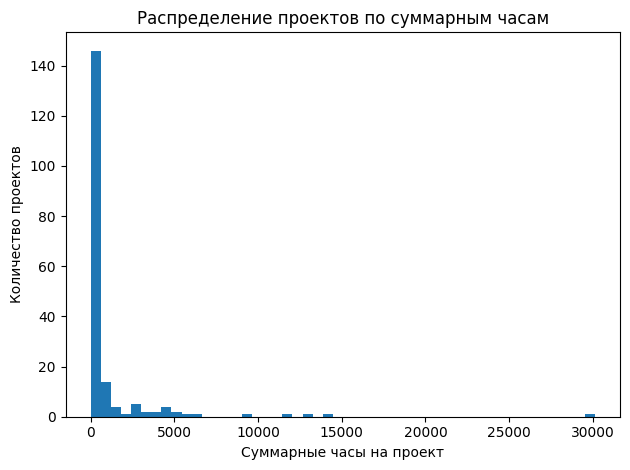

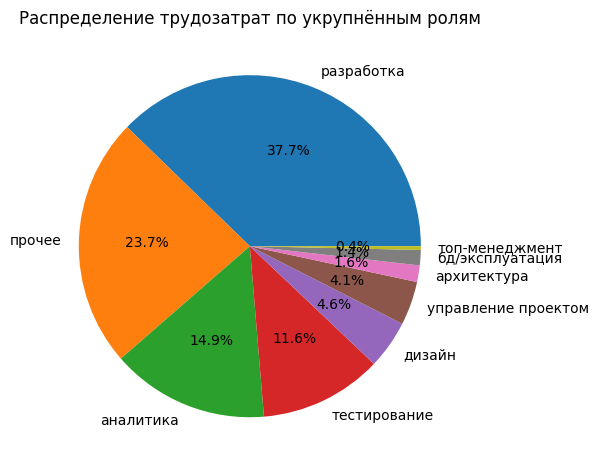

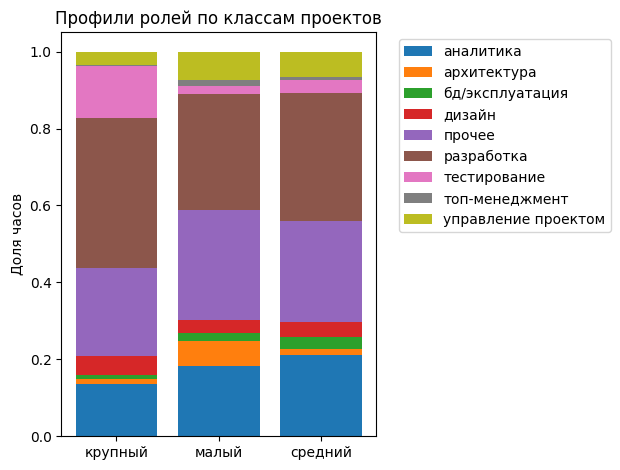


===== СВОДКА =====
Всего проектов: 187
Всего уникальных сотрудников: 599
Всего уникальных должностей: 221
Суммарно списано часов: 183,266


In [61]:
main('combined.csv', './output')